# EP-LHb model

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from EPLHb import EPLHb, gd, adam, NeuronalData

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

%matplotlib inline
from matplotlib import rcParams

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define model and optimizers

In [3]:
# class EPLHb(nn.Module):
#   def __init__(self, EP_size, LHb_size, DAN_size, prob_EP_to_LHb: float=1, fixed_sign: bool=False, neg_output: bool=True):
#     super(EPLHb,self).__init__()
#     self.EP_to_LHb = nn.Linear(EP_size, LHb_size, bias=True)
#     # nn.init.xavier_normal_(self.EP_to_LHb.weight)
#     self.LHb_to_DAN = nn.Linear(LHb_size, DAN_size, bias=True)
#     # nn.init.xavier_normal_(self.LHb_to_DAN.weight)

#     self.EP_size = EP_size
#     self.LHb_size = LHb_size
#     self.DAN_size = DAN_size
    
#     with torch.no_grad():
#       # Make EP to LHb sparse
#       n_zeros = int((1-prob_EP_to_LHb) * self.EP_to_LHb.weight.numel())
#       sparse_idx = torch.randperm(self.EP_to_LHb.weight.numel())[:n_zeros]
#       self.EP_to_LHb.weight.data.view(-1)[sparse_idx] = 0
      
#       # Make LHb to DAN all negative
#       self.neg_output = neg_output
#       if neg_output: self.LHb_to_DAN.weight.data = -torch.sign(self.LHb_to_DAN.weight)*self.LHb_to_DAN.weight

#       # Turn into fixed sign (obey Dale's law)
#       self.fixed_sign = fixed_sign
#       pos_neurons = {}
#       neg_neurons = {}
#       if fixed_sign:
#         for name, param in self.named_parameters():
#           if "weight" in name:
#             # Find each neuron is excitatory or inhibitory
#             pos_neurons[name] = torch.sum(param.data, axis=0) >= 0
#             neg_neurons[name] = torch.sum(param.data, axis=0) < 0
#             # Make all weights of that neuron excitatory or inhibitory
#             param.data[:,pos_neurons[name]] = torch.sign(param[:,pos_neurons[name]])*param[:,pos_neurons[name]]
#             param.data[:,neg_neurons[name]] = -torch.sign(param[:,neg_neurons[name]])*param[:,neg_neurons[name]]
    
#     self.relu = nn.ReLU()
#     self.tanh = nn.Tanh()

#     # Store original weights information
#     self.sparse_idx = sparse_idx
#     self.pos_neurons = pos_neurons
#     self.neg_neurons = neg_neurons
#     self.init_weights = self.record_params(calc_sign=False)

#   def enforce_weights(self):
#     with torch.no_grad():
#       # Keep EP to LHb sparse
#       self.EP_to_LHb.weight.data.view(-1)[self.sparse_idx] = 0
#       # Make LHb to DAN all negative
#       if self.neg_output:
#         self.LHb_to_DAN.weight.data=torch.minimum(self.LHb_to_DAN.weight, 0*self.LHb_to_DAN.weight)

#   def forward(self, input):
#     LHB_act = self.EP_to_LHb(input)
#     LHB_out = self.tanh(LHB_act)

#     DAN_act = self.LHb_to_DAN(LHB_out)
#     DAN_out = self.tanh(DAN_act)

#     return DAN_out
  
#   def record_params(self, calc_sign: bool=True):
#     # Save the network weights
#     recorded_params = {}
#     for name, param in self.named_parameters():
#         if param.requires_grad:
#           with torch.no_grad():
#             cur_data = param.data.detach().cpu().clone()
#             recorded_params[name] = (cur_data)
          
#           if calc_sign:
#             print(name)
#             frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
#             frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
#             frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
#             print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')
            
#     return recorded_params
  
#   def train_model(self,num_epochs,train_loader,optimizer,
#                   loss: str='MSE',
#                   print_epoch: bool=True):

#     # Define loss function
#     training_loss = []
#     if loss == 'MSE': loss_function = nn.MSELoss()
#     elif loss in 'CrossEntropyLoss': loss_function = nn.CrossEntropyLoss()
#     # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
#     # Train the network
#     for epoch in range(num_epochs):
#       for i, (data,labels) in enumerate(train_loader):
#         optimizer.zero_grad()

#         if data.ndim != 2: data = data.view(-1,self.EP_size)
#         outputs = self(data)

#         loss = loss_function(outputs.squeeze(), labels) #maybe need to flatten outputs
#         training_loss.append(loss.data.cpu())

#         loss.backward()
#         optimizer.step(init_weights=list(self.init_weights.values()))
#         self.enforce_weights()
        
#       if print_epoch:
#         print('Epoch [%d/%d], Loss: %.4f'  %(epoch+1, num_epochs, loss.data))
#       # scheduler.step()

#     return training_loss

In [4]:
# class NeuronalData(Dataset):
#     def __init__(self, inputs, labels):
#         self.inputs = inputs
#         self.labels = labels

#     def __len__(self):
#         return len(self.inputs)

#     def __getitem__(self, idx):
#         input_data = self.inputs[idx]
#         label = self.labels[idx]
#         return input_data, label

In [5]:
# class adam(torch.optim.Optimizer): 
# 	def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, fixed_sign: bool = False): 
# 		defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, fixed_sign=fixed_sign)
# 		super(adam, self).__init__(params, defaults) 

# 	def step(self, init_weights=None): 
# 		for group in self.param_groups: 
# 			for i, p in enumerate(group['params']): 
# 				if p.grad is None: 
# 					continue
# 				grad = p.grad.data 
# 				if grad.is_sparse: 
# 					raise RuntimeError("Adam does not support sparse gradients") 

# 				state = self.state[p] 

# 				# State initialization 
# 				if len(state) == 0: 
# 					state["step"] = 0
# 					# Momentum: Exponential moving average of gradient values 
# 					state["exp_avg"] = torch.zeros_like(p.data) 
# 					# RMS prop componenet: Exponential moving average of squared gradient values 
# 					state["exp_avg_sq"] = torch.zeros_like(p.data) 

# 				exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
# 				beta1, beta2 = group["betas"] 
# 				state["step"] += 1

# 				if group['weight_decay'] != 0: 
# 					grad = grad.add(p.data, alpha=group['weight_decay']) 

# 				# Decay the first and second moment running average coefficient
# 				exp_avg.lerp_(grad, 1 - beta1) # momentum
# 				exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1-beta2) # rms
			
# 				bias_correction1 = 1 - beta1 ** state["step"] 
# 				bias_correction2 = 1 - beta2 ** state["step"] 

# 				step_size = group["lr"] / bias_correction1
# 				bias_correction2_sqrt = math.sqrt(bias_correction2)

# 				denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(group["eps"])

# 				p.data.addcdiv_(exp_avg, denom, value=-step_size)
				
# 				if group["fixed_sign"]: 
# 					if init_weights is None: ValueError('Need to provide initial weights if fixed_sign is true!')
# 					flip_mask = init_weights[i].sign()*p.data.sign()<0
# 					p.data[flip_mask] = 0

## Generate data

In [6]:
EP_size = 300 # there are this many inputs that represent features and set to -1, 0, 1
LHB_size = 100 # number of neurons in the LHB that receive EP input
DAN_size = 10 # how DANs to calculate value
batch_size = 200 # the size of input data took for one iteration
num_epochs = 200
num_relearn_epochs = 200
lr = 1e-2 # size of step

label_type = 'digital' # or 'digital'
prob_EP_to_LHb = 1

In [7]:
#@title Generate the data

prob_input_active = 0.05 # probability that an input is active in each context
prob_output_active = 0.125
n_contexts = 5000

rands = torch.rand(n_contexts, EP_size, device=device)
train_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': train_labels = 2*rands-1
else: train_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
train_labels = torch.transpose(train_labels.repeat(DAN_size, 1).squeeze(), 0, 1)

rands = torch.rand(n_contexts, EP_size, device=device)
test_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': test_labels = 2*rands-1
else: test_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
test_labels = torch.transpose(test_labels.repeat(DAN_size, 1).squeeze(), 0, 1)

In [8]:
# Packaged into dataset
train_dataset = NeuronalData(train_data,train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NeuronalData(test_data,test_labels)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'Test labels')

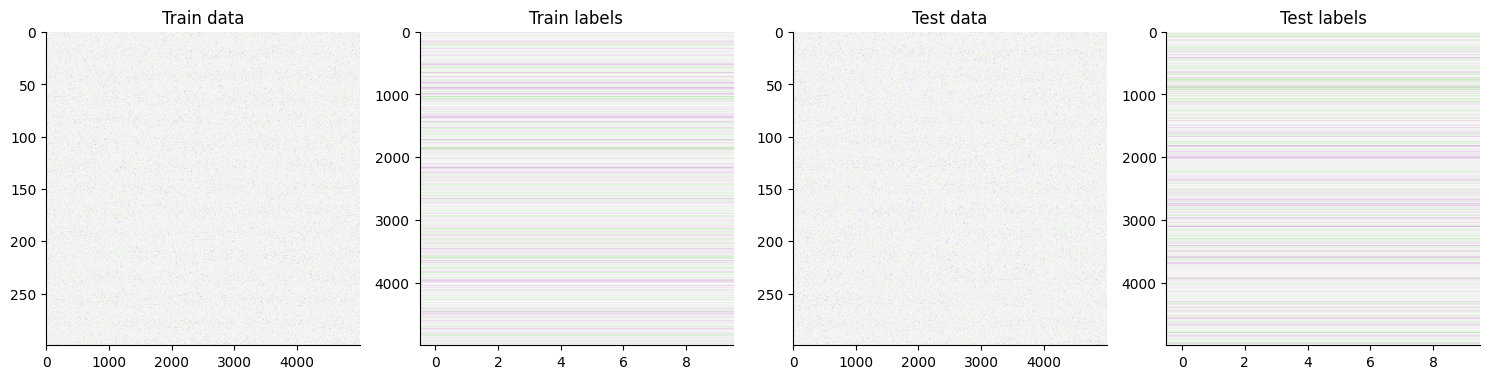

In [9]:
# Plot training data and label

fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data), cmap='PRGn', aspect=train_data.shape[0]/train_data.shape[1])
axs[0].set_title('Train data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels[None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels, cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[1].set_title('Train labels')

im = axs[2].imshow(torch.t(test_data), cmap='PRGn', aspect=test_data.shape[0]/test_data.shape[1])
axs[2].set_title('Test data')

if test_labels.ndim == 1: im = axs[3].imshow(test_labels[None], cmap='PRGn', aspect=test_labels.shape[0])
else: im = axs[3].imshow(test_labels, cmap='PRGn', aspect=test_labels.shape[1]/test_labels.shape[0])
axs[3].set_title('Test labels')

## Train co-release model

In [10]:
net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb=prob_EP_to_LHb,fixed_sign=False)
if torch.cuda.is_available():
  net.cuda()

# Define loss-function & optimizer
loss_function = nn.MSELoss()
optimizer = adam(net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
cr_training_loss = []

In [11]:
net

EPLHb(
  (EP_to_LHb): Linear(in_features=300, out_features=100, bias=True)
  (LHb_to_DAN): Linear(in_features=100, out_features=10, bias=True)
  (tanh): Tanh()
)

EP_to_LHb.weight
 Positive: 49.86000061035156%; Negative: 50.13999938964844%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 51.99999809265137%; Negative: 47.999998927116394%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%


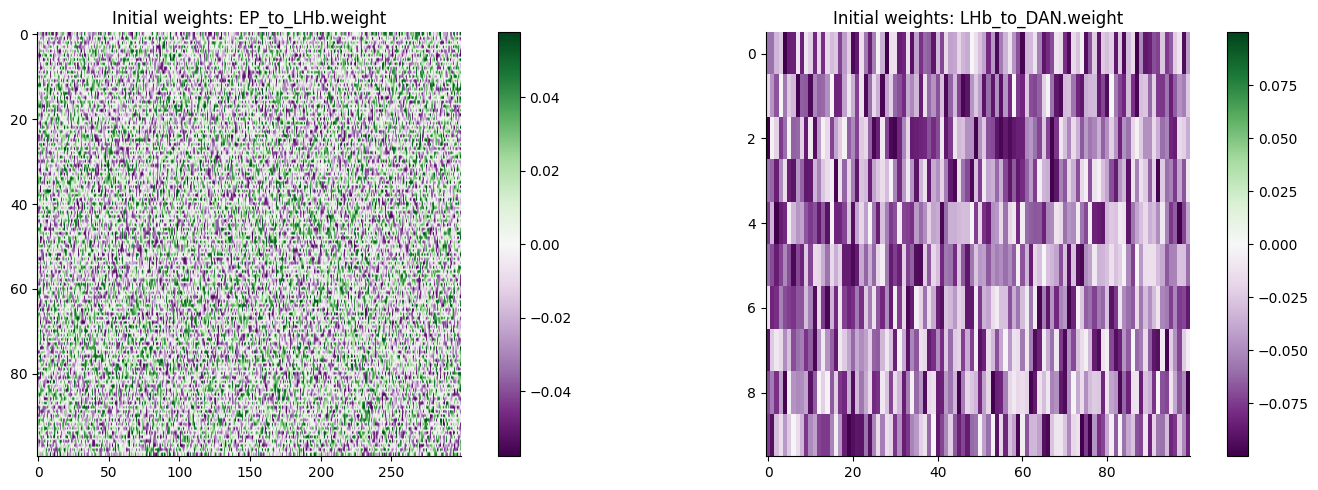

In [12]:
# Save the initial weights
initial_params_corelease = net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Epoch [1/200], Iteration: 0, Loss: 0.0060
Epoch [2/200], Iteration: 0, Loss: 0.0050
Epoch [3/200], Iteration: 0, Loss: 0.0073
Epoch [4/200], Iteration: 0, Loss: 0.0078
Epoch [5/200], Iteration: 0, Loss: 0.0051
Epoch [6/200], Iteration: 0, Loss: 0.0060
Epoch [7/200], Iteration: 0, Loss: 0.0057
Epoch [8/200], Iteration: 0, Loss: 0.0064
Epoch [9/200], Iteration: 0, Loss: 0.0076
Epoch [10/200], Iteration: 0, Loss: 0.0073
Epoch [11/200], Iteration: 0, Loss: 0.0087
Epoch [12/200], Iteration: 0, Loss: 0.0067
Epoch [13/200], Iteration: 0, Loss: 0.0069
Epoch [14/200], Iteration: 0, Loss: 0.0077
Epoch [15/200], Iteration: 0, Loss: 0.0083
Epoch [16/200], Iteration: 0, Loss: 0.0071
Epoch [17/200], Iteration: 0, Loss: 0.0077
Epoch [18/200], Iteration: 0, Loss: 0.0069
Epoch [19/200], Iteration: 0, Loss: 0.0074
Epoch [20/200], Iteration: 0, Loss: 0.0061
Epoch [21/200], Iteration: 0, Loss: 0.0057
Epoch [22/200], Iteration: 0, Loss: 0.0064
Epoch [23/200], Iteration: 0, Loss: 0.0068
Epoch [24/200], Iter

ValueError: Input could not be cast to an at-least-1D NumPy array

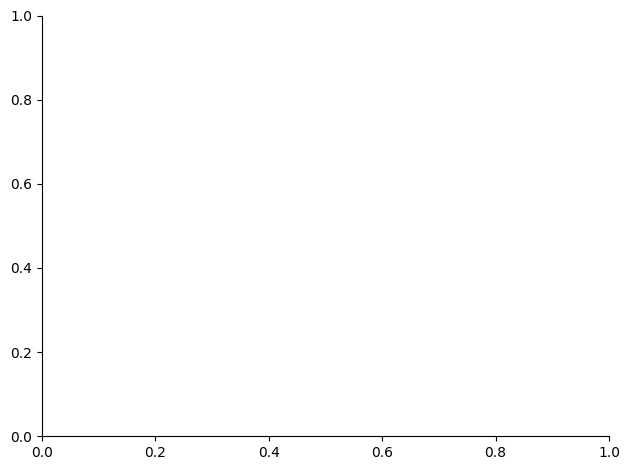

In [14]:
# Train the network
training_loss = net.train_model(num_epochs,train_loader,optimizer)
cr_training_loss.extend(training_loss)
print(len(training_loss))

# Plot training loss
plt.plot(cr_training_loss)

In [ ]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = net(train_data)
  test_outputs = net(test_data)

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels, rtol=1e-1)).sum() / train_labels.shape[0]
  test_accuracy = 100 * (torch.isclose(test_outputs.squeeze(), test_labels, rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.cpu().numpy(), train_outputs.cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(test_labels.cpu().numpy(), test_outputs.cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Test label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(test_accuracy))

In [ ]:
# Save the trianed parameters in paramList
trained_params_corelease = net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [ ]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Train fixed sign model

In [ ]:
fixed_sign_net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb=prob_EP_to_LHb,fixed_sign=True)
if torch.cuda.is_available():
  fixed_sign_net.cuda()

# Define loss-function & optimizer
fs_loss_function = nn.MSELoss()
fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
# fs_scheduler = torch.optim.lr_scheduler.ExponentialLR(fs_optimizer, gamma=0.95)
fs_training_loss = []

In [ ]:
# Save the initial weights
initial_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [ ]:
# Train the network
training_loss = fixed_sign_net.train_model(num_epochs,train_loader,fs_optimizer)
fs_training_loss.extend(training_loss)

In [ ]:
# Plot training loss
plt.plot(cr_training_loss, label='co-release loss')
plt.plot(fs_training_loss, label='fixed sign loss')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')

In [ ]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = fixed_sign_net(train_data)
  test_outputs = fixed_sign_net(test_data)

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels, rtol=1e-1)).sum() / train_labels.shape[0]
  test_accuracy = 100 * (torch.isclose(test_outputs.squeeze(), test_labels, rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(test_labels.flatten().cpu().numpy(), test_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Test label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(test_accuracy))

In [ ]:
# Save the trianed parameters in paramList
trained_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [ ]:
#@title What fraction of parameters flip sign?
for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_flip = (initial_params_fixed[key].sign()*trained_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_changed = (initial_params_fixed[key] != trained_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_fixed)[i]
    ax.scatter(initial_params_fixed[key].numpy(),trained_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Flip some weights and relearn

In [ ]:
#Generate the data by randomly flipping outputs

# prob_output_flip = 0.5

# nonzero_idx = train_labels.nonzero()
# flip_mask_nonzero = torch.rand(nonzero_idx.shape[0], device=device) < prob_output_flip
# flip_idx = nonzero_idx[flip_mask_nonzero].squeeze()
# train_labels_flipped = train_labels.clone()
# train_labels_flipped[flip_idx] *= -1

# n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
# print('Flipped percentage: ' + str(100*n_flip/train_labels.shape[0]) + '%')

In [ ]:
# Randomly select inputs, and flip corresponding labels
prob_EP_flip = 0.02

input_mask = torch.rand(EP_size,device=device) < prob_EP_flip
flip_EP = torch.linspace(1,EP_size,EP_size)[input_mask].to(torch.int32)
flip_idx = train_data.nonzero()[torch.isin(train_data.nonzero()[:,1], flip_EP),0].unique()

train_labels_flipped = train_labels.clone()
train_labels_flipped[flip_idx] *= -1

n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
print('Flipped percentage: %.3f%%, %d/%d' % (100*n_flip/train_labels.shape[0], n_flip, n_contexts))
print('Flipped EP neurons: ' + str(flip_EP.numpy()))

flip_dataset = NeuronalData(train_data,train_labels_flipped)
flip_loader = DataLoader(dataset=flip_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_labels_flipped[flip_idx].shape

In [ ]:
# Plot training data and label
fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[0].set_title('Original data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels[flip_idx][None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels[flip_idx], cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[1].set_title('Original labels')

im = axs[2].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[2].set_title('Flipped data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels_flipped[flip_idx][None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels_flipped[flip_idx], cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[3].set_title('Flipped labels')

In [ ]:
# Train the network
optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
training_loss = net.train_model(num_epochs,flip_loader,optimizer)
cr_training_loss.extend(training_loss)

fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
training_loss = fixed_sign_net.train_model(num_epochs,flip_loader,fs_optimizer)
fs_training_loss.extend(training_loss)

In [ ]:
# Plot training loss
plt.plot(cr_training_loss, label='co-release loss')
plt.plot(fs_training_loss, label='fixed sign loss')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')

## Relearn weights for co-release model

In [ ]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = net(train_data)
  flipped_outputs = net(train_data[flip_idx,:])

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels_flipped, rtol=1e-1)).sum() / train_labels.shape[0]
  flipped_accuracy = 100 * (torch.isclose(flipped_outputs.squeeze(), train_labels_flipped[flip_idx], rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(train_labels_flipped[flip_idx].flatten().cpu().numpy(), flipped_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Flipped label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(flipped_accuracy))

In [ ]:
# Save the trianed parameters in paramList
relearn_params_corelease = net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in relearn_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Relearn weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [ ]:
#@title What fraction of parameters flip sign?
for key in trained_params_corelease:
    n_weights=trained_params_corelease[key].numel()
    n_flip = (trained_params_corelease[key].sign()*relearn_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in trained_params_corelease:
    n_weights=trained_params_corelease[key].numel()
    n_changed = (trained_params_corelease[key] != relearn_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values
fig, axs = plt.subplots(2,int(len(relearn_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(relearn_params_corelease)[i]
    ax.scatter(trained_params_corelease[key].numpy(),relearn_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Relearn weights for fixed sign model

In [ ]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = fixed_sign_net(train_data)
  flipped_outputs = fixed_sign_net(train_data[flip_idx,:])

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels_flipped, rtol=1e-1)).sum() / train_labels.shape[0]
  flipped_accuracy = 100 * (torch.isclose(flipped_outputs.squeeze(), train_labels_flipped[flip_idx], rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(train_labels_flipped[flip_idx].flatten().cpu().numpy(), flipped_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Flipped label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(flipped_accuracy))

In [ ]:
# Save the trianed parameters in paramList
relearn_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in relearn_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Relearn weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [ ]:
#@title What fraction of parameters flip sign?
for key in trained_params_fixed:
    n_weights=trained_params_fixed[key].numel()
    n_flip = (trained_params_fixed[key].sign()*relearn_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in trained_params_fixed:
    n_weights=trained_params_fixed[key].numel()
    n_changed = (trained_params_fixed[key] != relearn_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))


# Plot initial vs trained values
fig, axs = plt.subplots(2,int(len(relearn_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(relearn_params_fixed)[i]
    ax.scatter(trained_params_fixed[key].numpy(),relearn_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Weight change analysis

In [ ]:
# Plot flipped EP neuron weight changes
n_row = 2
n_col = flip_EP.shape[0]

fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

key = 'EP_to_LHb.weight'
for i, neuron in enumerate(flip_EP):
    weight_history_corelease = [initial_params_corelease[key][:,neuron].flatten(),
                                trained_params_corelease[key][:,neuron].flatten(),
                                relearn_params_corelease[key][:,neuron].flatten()]

    weight_history_fixed = [initial_params_fixed[key][:,neuron].flatten(),
                            trained_params_fixed[key][:,neuron].flatten(),
                            relearn_params_fixed[key][:,neuron].flatten()]

    axs.flatten()[i].plot(weight_history_corelease)
    axs.flatten()[i].set_xlabel('Training phase')
    axs.flatten()[i].set_ylabel('Weight')
    axs.flatten()[i].set_title('Co-release: %s (EP neuron %d)' %(key, neuron))
    axs.flatten()[i+n_col].plot(weight_history_fixed)
    axs.flatten()[i+n_col].set_xlabel('Training phase')
    axs.flatten()[i+n_col].set_ylabel('Weight')
    axs.flatten()[i+n_col].set_title('Fixed sign: %s (EP neuron %d)' %(key, neuron))

plt.tight_layout()
plt.show()

In [ ]:
# # Plot overall weight changes
# n_row = 2
# n_col = len(relearn_params_corelease)

# fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
# plt.subplots_adjust(hspace=0.5)

# for i, ax in enumerate(axs.flatten()):
#     if i >= len(list(initial_params_corelease)): break
#     key = list(initial_params_corelease)[i]
#     print(key)
#     weight_history_corelease = [initial_params_corelease[key].flatten(),
#                                 trained_params_corelease[key].flatten(),
#                                 relearn_params_corelease[key].flatten()]

#     weight_history_fixed = [initial_params_fixed[key].flatten(),
#                             trained_params_fixed[key].flatten(),
#                             relearn_params_fixed[key].flatten()]

#     axs.flatten()[i].plot(weight_history_corelease)
#     axs.flatten()[i].set_xlabel('Training phase')
#     axs.flatten()[i].set_ylabel('Weight')
#     axs.flatten()[i].set_title('Co-release: ' + key)
#     axs.flatten()[i+n_col].plot(weight_history_fixed)
#     axs.flatten()[i+n_col].set_xlabel('Training phase')
#     axs.flatten()[i+n_col].set_ylabel('Weight')
#     axs.flatten()[i+n_col].set_title('Fixed sign: ' + key)

# plt.tight_layout()
# plt.show()

## Train multiple networks per condition

Different initialization scenarios
- random initialization of every synapses
- Dale's law initialization of every synapses

Different network structure
- LHb to DAN is all inhibitory + LHb to LHb is all excitatory (if RNN)
- Every layer have mixed excitatory/inhibitory output

Different update methods
- Normal ADAM
- Fixed sign ADAM

In [ ]:
EP_size = 300 # there are this many inputs that represent features and set to -1, 0, 1
LHB_size = 100 # number of neurons in the LHB that receive EP input
DAN_size = 1 # how DANs to calculate value
batch_size = 200 # the size of input data took for one iteration
num_epochs = 200
num_relearn_epochs = 200
lr = 1e-2 # size of step

label_type = 'digital' # or 'digital'
prob_EP_to_LHb = 1

n_networks = 20 # number of networks to train

In [ ]:
#@title Generate the data

prob_input_active = 0.05 # probability that an input is active in each context
prob_output_active = 0.125
n_contexts = 5000

rands = torch.rand(n_contexts, EP_size, device=device)
train_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': train_labels = 2*rands-1
else: train_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
# train_labels = torch.transpose(train_labels.repeat(DAN_size, 1), 0, 1)

train_dataset = NeuronalData(train_data,train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Plot training data and label
fig, axs = plt.subplots(1,2, figsize=(15,5))
im = axs[0].imshow(torch.t(train_data), cmap='PRGn', aspect=train_data.shape[0]/train_data.shape[1])
axs[0].set_title('Train data')
im = axs[1].imshow(train_labels[None], cmap='PRGn', aspect=train_labels.shape[0])
axs[1].set_title('Train labels')

In [ ]:
# Randomly select inputs, and flip corresponding labels
prob_EP_flip = 0.02

input_mask = torch.rand(EP_size,device=device) < prob_EP_flip
flip_EP = torch.linspace(1,EP_size,EP_size)[input_mask].to(torch.int32)
flip_idx = train_data.nonzero()[torch.isin(train_data.nonzero()[:,1], flip_EP),0].unique()

train_labels_flipped = train_labels.clone()
train_labels_flipped[flip_idx] *= -1

n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
print('Flipped percentage: %.3f%%, %d/%d' % (100*n_flip/train_labels.shape[0], n_flip, n_contexts))
print('Flipped EP neurons: ' + str(flip_EP.numpy()))

flip_dataset = NeuronalData(train_data,train_labels_flipped)
flip_loader = DataLoader(dataset=flip_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Plot training data and label
fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[0].set_title('Original data')

im = axs[1].imshow(train_labels[flip_idx][None], cmap='PRGn', aspect=train_labels[flip_idx].shape[0])
axs[1].set_title('Original labels')

im = axs[2].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[2].set_title('Flipped data')

im = axs[3].imshow(train_labels_flipped[flip_idx][None], cmap='PRGn', aspect=train_labels_flipped[flip_idx].shape[0])
axs[3].set_title('Flipped labels')

### Train multiple co-release models

In [ ]:
cr_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=False)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    # Train on flipped data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    cr_training_loss_summary.append(net_training_loss)
    print('Finished training co-release network %d/%d' %(i,n_networks))

# Convert list to numpy array
cr_training_loss_summary = np.array(cr_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(cr_training_loss_summary[i])
#     ax.set_title('Corelease # %d' %(i+1))

### Train multiple fixed sign models

In [ ]:
fs_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=True)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    # Train on flipped data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    fs_training_loss_summary.append(net_training_loss)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_training_loss_summary = np.array(fs_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

### Train fixed sign without negative output

In [ ]:
fs_posneg_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=True, neg_output=False)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    # Train on flipped data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    fs_posneg_training_loss_summary.append(net_training_loss)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_posneg_training_loss_summary = np.array(fs_posneg_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

### Plot summary

In [ ]:
mean_cr_loss = np.mean(cr_training_loss_summary,axis=0)
sem_cr_loss = stats.sem(cr_training_loss_summary)
mean_fs_loss = np.mean(fs_training_loss_summary,axis=0)
sem_fs_loss = stats.sem(fs_training_loss_summary)
mean_fs_posneg_loss = np.mean(fs_posneg_training_loss_summary,axis=0)
sem_fs_posneg_loss = stats.sem(fs_posneg_training_loss_summary)

# Plot
x = np.linspace(1,mean_cr_loss.shape[0],num=mean_cr_loss.shape[0],dtype='int32')
plt.plot(mean_cr_loss, label='Co-release')
plt.fill_between(x,mean_cr_loss+sem_cr_loss,mean_cr_loss-sem_cr_loss,alpha=0.2)
plt.plot(mean_fs_loss, label='Fixed sign')
plt.fill_between(x,mean_fs_loss+sem_fs_loss,mean_fs_loss-sem_fs_loss,alpha=0.2)
plt.plot(mean_fs_posneg_loss, label='Fixed sign without neg output')
plt.fill_between(x,mean_fs_posneg_loss+sem_fs_posneg_loss,mean_fs_posneg_loss-sem_fs_posneg_loss,alpha=0.2)

plt.xlabel('Trianing epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()